# Data analysis of  venues in  Bangalore & Hyderabad, India

## Introduction

In Asia, growth is increasingly being driven by successful cities or regions within countries. Two of Asia’s three fastest-growing cities are Bangalore and Hyderabad in southern India. According to Oxford Economics, Bangalore should achieve average annual real GDP growth of 9.9% over 2020-2024 – far above aggregate growth for India of 6.8% and average growth for Asian cities of 3.9% over the same period. The third fastest-growing Asian city is Hyderabad with average GDP growth of  7.8%.

This dynamic nature of cities attracts the visitors from all across the world. Due to its dynamic changes, the venues in the cities also change dynamically. This makes it difficult to obtain information about venues in cities for visitors based on their interests.

To solve this problem, we use data visualization & machine learning techniques to cluster venue data based on venue categories such as Restaurants, bars, hotels etc. The insights like are the restaurants good or bad?, are there any historical places to visit?, how are the hotels for stay? etc are extracted from venue data could be used to recommend visitors the best city based on their interests. We are considering only two cities (Bangalore & Hyderabad) for this study.

<h1>Table of contents </h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li><a href="#getting_started">Getting Started</a></li>   
        <li><a href="#data_collection">Data Collection</a></li>
        <li><a href="#data_cleaning">Data Cleaning</a></li>
        <li><a href="#data_exploration">Data exploration and Results</a></li>
        <li><a href="#Clustering and discusion">Clustering of Venue Categories and Key take aways</a></li>
        <li><a href="#conclusions">Conclusions</a></li>
    </ul>
</div>
<br>
<hr>

### Getting Started

In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection

### Foursquare API

Foursquare API is a location based service to explore world around them. Here API is used to get venue list in Bangalore & Hyderabad based on geographical coordinates (latitude,longitude).  
Foursquare API requires Client ID & Client Secret key to connect to the Foursquare platform.

#### Geographical coordinates of Bangalore & Hyderabad

In [ ]:
#Get from Googlemaps
lat_Bangalore='12.9716'
long_Bangalore='77.5946'
lat_Hyderabad='17.387'
long_Hyderabad='78.491'

print('The geo coordinates of Bangalore  are {} & {} '.format(lat_Bangalore,long_Bangalore))
print('The geo coordinates of Hyderabad  are {} & {} '.format(lat_Hyderabad,long_Hyderabad))

The geo coordinates of Bangalore  are 12.9716 & 77.5946 
The geo coordinates of Hyderabad  are 17.387 & 78.491 


### Fetch all venues in Bangalore & Hyderabad within 5 km radius

In [ ]:
CLIENT_ID=    '<###CLIENT_ID###>'
CLIENT_SECRET= '<###CLIENT_SECRET###>'
Radius=5000 # 5 km
LIMIT=100
VERSION='20200727'

#### Define get_category_type function to get current category for each venue

In [ ]:
def get_category_type(row):
    try:
        categories_list=row['categories']
    except:
        categories_list=row['venue.categories']
    if len(categories_list)==0:
        return None
    else:
        return categories_list[0]['name']

Now we will call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows',None)
offset=0

#Define a function to fetch venues from API

def venue_data(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,limit,Radius,offset):
    
    API_venues=pd.DataFrame(columns=['id','name','categories','lat','lng','address'])
    total_venues=0
    while(True):
        url=('https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&limit={}&radius={}&offset={}').format(
            CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,limit,Radius,offset)
        
        results=requests.get(url).json()
        venues_fetched=len(results['response']['groups'][0]['items'])
        total_venues=total_venues+venues_fetched
        print('{} venues are fetched within {} km radius'.format(total_venues,Radius/1000))
        
        venues=results['response']['groups'][0]['items']
        venues=json_normalize(venues)
        
        #Filter the columns
        filtered_cols=['venue.id','venue.name','venue.categories','venue.location.lat','venue.location.lng',\
                       'venue.location.address']
        venues=venues.loc[:,filtered_cols]
        
        #Filter the category for each row
        venues['venue.categories']=venues.apply(get_category_type,axis=1)
        
        #Clean all column names
        venues.columns=[col.split('.')[-1] for col in venues.columns]
        API_venues=pd.concat([API_venues,venues],axis=0,sort=False)
        
        if venues_fetched<100:
            break
        else:
            offset=offset+100
    API_venues=API_venues.reset_index(drop=True)
    return API_venues,total_venues

In [ ]:
# Fetch the venues for Bangalore
Bangalore_venues,total_venues=venue_data(CLIENT_ID,CLIENT_SECRET,VERSION,lat_Bangalore,long_Bangalore,LIMIT,Radius,offset)
print('\nTotal {} venues are fetched in Bangalore within {} km radius'.format(total_venues,Radius/1000))

100 venues are fetched within 5.0 km radius
200 venues are fetched within 5.0 km radius
203 venues are fetched within 5.0 km radius

Total 203 venues are fetched in Bangalore within 5.0 km radius


In [ ]:
print('There are {} rows & {} columns in Bangalore_venues'.format(Bangalore_venues.shape[0],Bangalore_venues.shape[1]))

There are 203 rows & 6 columns in Bangalore_venues


In [ ]:
Bangalore_venues.head()

,id,name,categories,lat,lng,address
0,4bcd805cfb84c9b61512223e,UB City,Shopping Mall,12.971709,77.595905,at Vittal Mallya Rd
1,51d1245e498ef93fd0e713bb,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051,24/1 Vittal Mallya Road
2,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,"52,53"
3,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,UB City Level 2 Concorde Block
4,4bbc4513e45295217db855a4,Cubbon Park,Park,12.977042,77.595277,M G Road


In [ ]:
# Fetch the venues for Hyderabad
Hyderabad_venues,total_venues=venue_data(CLIENT_ID,CLIENT_SECRET,VERSION,lat_Hyderabad,long_Hyderabad,LIMIT,Radius,offset)
print('\nTotal {} venues are fetched in Hyderabad within {} km radius'.format(total_venues,Radius/1000))

93 venues are fetched within 5.0 km radius

Total 93 venues are fetched in Hyderabad within 5.0 km radius


In [ ]:
Hyderabad_venues.head()

,id,name,categories,lat,lng,address
0,4dc4a65e18506de4adc5d5e5,Pragati,South Indian Restaurant,17.388088,78.481134,"Kandaswamy Lane, Sultan Bazaar, Koti Andhra Pr..."
1,4d3d4eca14aa8cfaa6d6b15e,Santosh Dhaba,Indian Restaurant,17.388485,78.479509,NaN
2,4df9c65c62e1e9a24367f9e5,King & Cardinal,Burger Joint,17.400678,78.488575,Himayatnagar
3,4cdd08d4fc973704fe47d905,Mayur Pan Shop,Juice Bar,17.388894,78.480578,Hanuman Tekdi Rd.
4,4e009da21838cb6a1acb225e,Minerva Coffee Shop,Indian Restaurant,17.401410,78.485672,Himyathnagar


#### Now the get the venue  details

In [ ]:
# Define a function to fetch users venue data

def user_data(CLIENT_ID,CLIENT_SECRET,VERSION,VENUE_ID):
    
    url='https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        VENUE_ID,CLIENT_ID,CLIENT_SECRET,VERSION)
        
    #params=dict(CLIENT_ID,CLIENT_SECRET,VERSION)
        
    results=requests.get(url=url).json()
        
    #Get tipcount
    venue_stats=results['response']['venue']['stats']
    venue_stats=json_normalize(venue_stats)
    tipcount=venue_stats.reset_index(drop=True)
        
    #Get like_count
    venue_likes=results['response']['venue']['likes']
    like_count=json_normalize(venue_likes)
    like_count=like_count.reset_index(drop=True)
        
    #Get rating
    venue_rating=results['response']['venue']['rating']
        
    #Get rating signals
    venue_ratingsignals=results['response']['venue']['ratingSignals']
    
    return tipcount,like_count,venue_rating,venue_ratingsignals    

In [ ]:
#Fetch the venue details for each venue in Bangalore

rating_list=[]
ratingSignals_list=[]
tipcount_list=[]
like_count_list=[]
id_list=[]

for venue_id in Bangalore_venues['id'][:51]:
    id_list.append(venue_id)
    tipcount,like_count,venue_rating,venue_ratingsignals=user_data(CLIENT_ID,CLIENT_SECRET,VERSION,venue_id)
    rating_list.append(venue_rating)
    ratingSignals_list.append(venue_ratingsignals)
    tipcount_list.append(tipcount.loc[:,'tipCount'][0])
    like_count_list.append(like_count.loc[:,'count'][0])
    
Bvenue_details=pd.DataFrame(id_list,columns=['id'])
Bvenue_details['tipcount']=tipcount_list
Bvenue_details['like_count']=like_count_list
Bvenue_details['rating']=rating_list
Bvenue_details['ratingSignals']=ratingSignals_list


In [ ]:
print('There are {} rows & {} columns in Bangalore venue details'.format(Bvenue_details.shape[0],Bvenue_details.shape[1]))

There are 51 rows & 5 columns in Bangalore venue details


In [ ]:
Bvenue_details.head()

,id,tipcount,like_count,rating,ratingSignals
0,4bcd805cfb84c9b61512223e,104,657,9.0,802
1,51d1245e498ef93fd0e713bb,36,128,8.7,166
2,520390f3498ebe0f1dd63e9e,37,111,8.9,147
3,4bc1cd90b492d13a4e74a660,65,127,8.6,188
4,4b895510f964a520442c32e3,70,140,8.4,204


In [ ]:
#Fetch the venue details for each venue in Hyderabad

rating_list=[]
ratingSignals_list=[]
tipcount_list=[]
like_count_list=[]
id_list=[]
count=0
for venue_id in Hyderabad_venues['id'][:51]:
    id_list.append(venue_id)
    tipcount,like_count,venue_rating,venue_ratingsignals=user_data(CLIENT_ID,CLIENT_SECRET,VERSION,venue_id)
    rating_list.append(venue_rating)
    ratingSignals_list.append(venue_ratingsignals)
    tipcount_list.append(tipcount.loc[:,'tipCount'][0])
    like_count_list.append(like_count.loc[:,'count'][0])
    
Hvenue_details=pd.DataFrame(id_list,columns=['id'])
Hvenue_details['tipcount']=tipcount_list
Hvenue_details['like_count']=like_count_list
Hvenue_details['rating']=rating_list
Hvenue_details['ratingSignals']=ratingSignals_list


In [ ]:
print('There are {} rows & {} columns in Hyderabad venue details'.format(Hvenue_details.shape[0],Hvenue_details.shape[1]))

There are 51 rows & 5 columns in Hyderabad venue details


In [ ]:
Hvenue_details.head()

,id,tipcount,like_count,rating,ratingSignals
0,4dc4a65e18506de4adc5d5e5,15,38,8.3,55
1,4d3d4eca14aa8cfaa6d6b15e,15,23,8.2,40
2,4df9c65c62e1e9a24367f9e5,20,35,8.4,57
3,4cdd08d4fc973704fe47d905,21,48,7.9,71
4,4e009da21838cb6a1acb225e,31,74,8.3,108


## Data Cleaning

#### We are considering only top 51 venues for this study due to limited API calls.

In [ ]:
#Bangalore venues
Bvenues_df=pd.merge(Bangalore_venues,Bvenue_details,on='id',how='inner')
Bvenues_df.shape

(51, 10)

In [ ]:
Bvenues_df.head()

,id,name,categories,lat,lng,address,tipcount,like_count,rating,ratingSignals
0,4bcd805cfb84c9b61512223e,UB City,Shopping Mall,12.971709,77.595905,at Vittal Mallya Rd,104,657,9.0,802
1,51d1245e498ef93fd0e713bb,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051,24/1 Vittal Mallya Road,36,128,8.7,166
2,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,"52,53",37,111,8.9,147
3,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,UB City Level 2 Concorde Block,65,127,8.6,188
4,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,"3rd Flr., UB City, Vittal Mallya Rd.",70,140,8.4,204


In [ ]:
# The code was removed by Watson Studio for sharing.

In [ ]:
#Hyderabad venues
Hvenues_df=pd.merge(Hyderabad_venues,Hvenue_details,on='id',how='inner')
Hvenues_df.shape

(51, 10)

In [ ]:
Hvenues_df.head()

,id,name,categories,lat,lng,address,tipcount,like_count,rating,ratingSignals
0,4dc4a65e18506de4adc5d5e5,Pragati,South Indian Restaurant,17.388088,78.481134,"Kandaswamy Lane, Sultan Bazaar, Koti Andhra Pr...",15,38,8.3,55
1,4d3d4eca14aa8cfaa6d6b15e,Santosh Dhaba,Indian Restaurant,17.388485,78.479509,NaN,15,23,8.2,40
2,4df9c65c62e1e9a24367f9e5,King & Cardinal,Burger Joint,17.400678,78.488575,Himayatnagar,20,35,8.4,57
3,4cdd08d4fc973704fe47d905,Mayur Pan Shop,Juice Bar,17.388894,78.480578,Hanuman Tekdi Rd.,21,48,7.9,71
4,4e009da21838cb6a1acb225e,Minerva Coffee Shop,Indian Restaurant,17.401410,78.485672,Himyathnagar,31,74,8.3,108


In [ ]:
# The code was removed by Watson Studio for sharing.

## Data exploration & Results

### Create a folium map centered around Bangalore

In [ ]:
#!pip install folium
import folium
Bangalore_map=folium.Map(location=[lat_Bangalore,long_Bangalore],zoom_start=13)
folium.features.Marker(
(lat_Bangalore,long_Bangalore),
popup='Bangalore Central',
icon=folium.Icon(color='red',icon_color='white',icon='male',angle=0,prefix='fa')).add_to(Bangalore_map)
Bangalore_map

In [ ]:
#Create a list of latitude & longitude pairs
#For Bangalore
location_B=Bangalore_venues[['lat','lng']]
locationlist_B=location_B.values.tolist()
locationlist_B[0]

[12.971708980695311, 77.59590528412356]

### Explore all venues around Bangalore

In [ ]:
for point in range(0,len(locationlist_B)):
    folium.features.Marker(
    locationlist_B[point],
    popup=Bangalore_venues['name'][point]+', '+ Bangalore_venues['categories'][point],
    icon=folium.Icon(color='darkblue',icon_color='white',icon='male',angle=0,prefix='fa')
    ).add_to(Bangalore_map)
Bangalore_map

In [ ]:
Bangalore_venues['categories'].unique()

array(['Shopping Mall', 'Hotel', 'Deli / Bodega', 'Italian Restaurant',
       'Park', 'Japanese Restaurant', 'French Restaurant', 'Burger Joint',
       'Sushi Restaurant', 'Lounge', 'Cupcake Shop', 'Ice Cream Shop',
       'American Restaurant', 'Cricket Ground', 'Asian Restaurant',
       'Gym / Fitness Center', 'Breakfast Spot', 'Plaza', 'Bakery',
       'Furniture / Home Store', 'Fried Chicken Joint', 'Boutique',
       'Bookstore', 'Toy / Game Store', 'Tea Room', 'Indian Restaurant',
       'Coffee Shop', 'Café', 'Pub', 'Brewery', 'Afghan Restaurant',
       'Cocktail Bar', 'Andhra Restaurant', 'Steakhouse',
       'Seafood Restaurant', 'Bed & Breakfast',
       'Vegetarian / Vegan Restaurant', 'Racetrack', 'Soccer Stadium',
       'Department Store', 'Art Gallery', 'Dessert Shop',
       'Botanical Garden', 'Clothing Store',
       'Eastern European Restaurant', 'Mediterranean Restaurant',
       'Snack Place', 'Bistro', 'Juice Bar', 'Movie Theater',
       'Monument / Landmark'

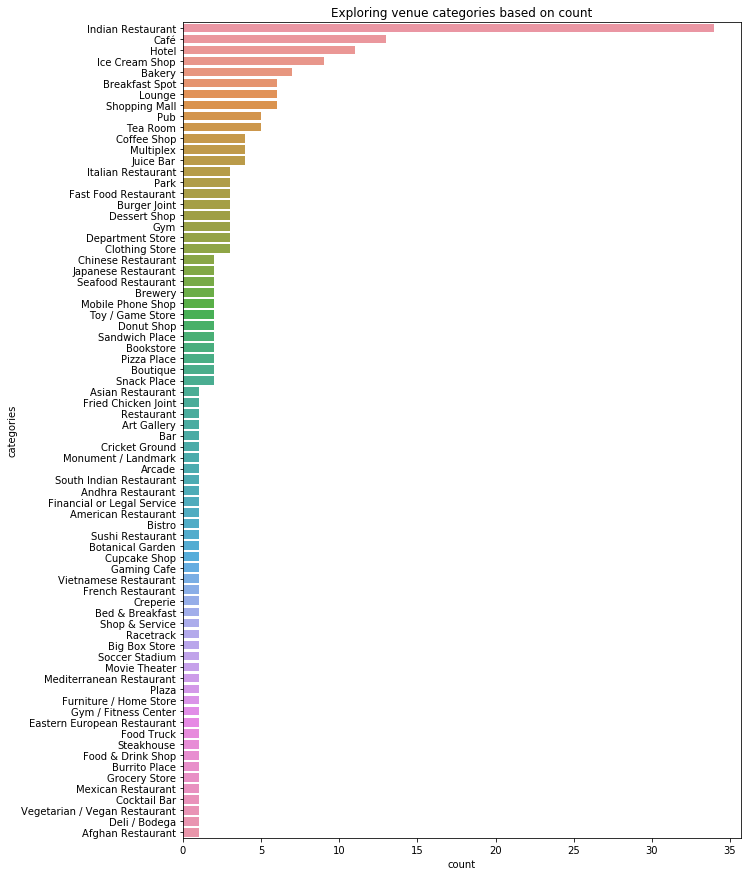

In [ ]:
plt.figure(figsize=(10,15))
sns.countplot(y=Bangalore_venues['categories'],order=Bangalore_venues['categories'].value_counts().index)
plt.title('Exploring venue categories based on count')
plt.show()

A wide variety of cuisines are available such as Indian, Japanese, Mexico, French, American, Burger joint, Seafood  & a lot more. Bangalore has the highest number of Indian restaurants than any other restaurants. If you are a foodie, Bangalore is best for you.

### Create a folium map centered around Hyderabad

In [ ]:
Hyderabad_map=folium.Map(location=[lat_Hyderabad,long_Hyderabad],zoom_start=13)
folium.features.Marker(
(lat_Hyderabad,long_Hyderabad),
popup='Hyderabad Central',
icon=folium.Icon(color='red',icon_color='white',icon='male',angle=0,prefix='fa')).add_to(Hyderabad_map)
Hyderabad_map

In [ ]:
#Create a list of latitude & longitude pairs
#For Hyderabad
location_H=Hyderabad_venues[['lat','lng']]
locationlist_H=location_H.values.tolist()
locationlist_H[0]

[17.38808781386729, 78.48113363131787]

### Explore all venues around Hyderabad

In [ ]:
for point in range(0,len(locationlist_H)):
    folium.features.Marker(
    locationlist_H[point],
    popup=Hyderabad_venues['name'][point]+', '+Hyderabad_venues['categories'][point],
    icon=folium.Icon(color='darkblue',icon_color='white',icon='male',angle=0,prefix='fa')
    ).add_to(Hyderabad_map)
Hyderabad_map

In [ ]:
Hyderabad_venues['categories'].unique()

array(['South Indian Restaurant', 'Indian Restaurant', 'Burger Joint',
       'Juice Bar', 'Bakery', 'Snack Place', 'Dessert Shop',
       'Ice Cream Shop', 'Food Truck', 'Diner', 'Lounge', 'Chaat Place',
       'History Museum', 'Hotel', 'Café', 'Multiplex', 'Shoe Store',
       'Movie Theater', 'Scenic Lookout', 'Chinese Restaurant',
       'Science Museum', 'Restaurant', 'Hyderabadi Restaurant',
       'Coffee Shop', 'Fast Food Restaurant', 'Monument / Landmark',
       'Lake', 'Neighborhood', 'Bistro', 'Department Store',
       'Breakfast Spot', 'Smoke Shop', 'Food Court', 'Pizza Place',
       'Hotel Bar', 'Bar', 'Food', 'Sandwich Place', 'Gaming Cafe',
       'Asian Restaurant', 'Middle Eastern Restaurant', 'Train Station',
       'Hookah Bar', 'Cheese Shop', 'Convenience Store',
       'Food & Drink Shop', 'Shopping Mall'], dtype=object)

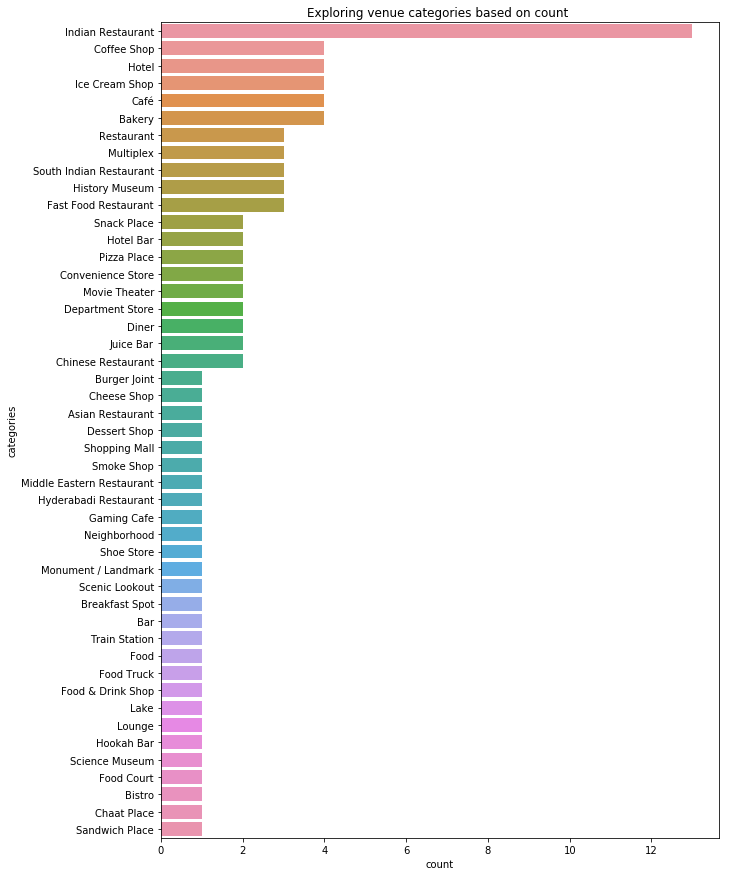

In [ ]:
plt.figure(figsize=(10,15))
sns.countplot(y=Hyderabad_venues['categories'],order=Hyderabad_venues['categories'].value_counts().index)
plt.title('Exploring venue categories based on count ')
plt.show()

We could see that number of restaurants are less around Hyderabad compared to Bangalore, includes South Indian, Hyderabadi, Indian, Asian, Chinese, Fast Food & Middle Eastern. The majority of the venues are Indian Restaurants. If you love Indian recipes, specially Hyderabadi Biriyani, Hyderabad is best for you.

### Exploring top 51 venue categories based on like count (number of users who have liked that venue)

<Figure size 864x1296 with 0 Axes>

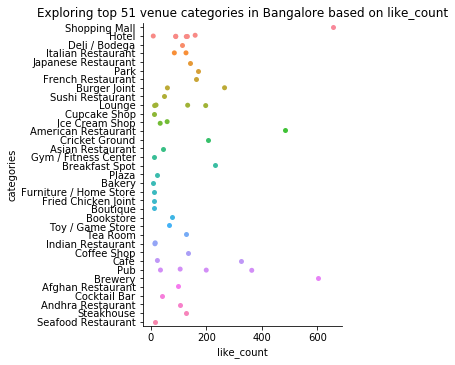

In [ ]:
#In Bangalore
plt.figure(figsize=(12,18))
sns.catplot(x='like_count',y='categories',data=Bvenues_df)
plt.xlabel('like_count')
plt.title('Exploring top 51 venue categories in Bangalore based on like_count')
plt.show()

From above plot , we could say that, the most liked venue categories are Shopping Mall & Brewery and the least liked categories are Seafood restaurant, Gym/Fitness center,Bakery & Hotel. All other restaurants except American got average number of likes.

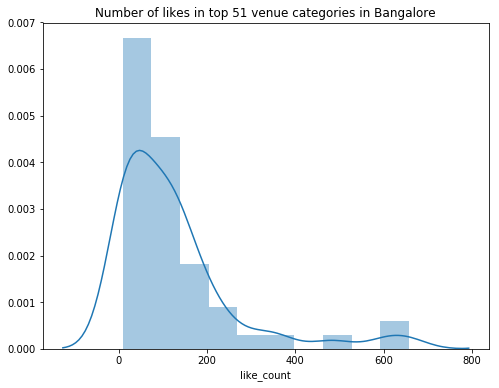

In [ ]:
# Average number of user likes that have been reported in venuue categories
plt.figure(figsize=(8,6))
sns.distplot(Bvenues_df['like_count'])
plt.title('Number of likes in top 51 venue categories in Bangalore')
plt.show()

In [ ]:
print('Average number of user likes that have been reported in top 51 venuue categories in Bangalore is {}'.format(int(Bvenues_df['like_count'].mean())))

Average number of user likes that have been reported in top 51 venuue categories in Bangalore is 125


<Figure size 864x1296 with 0 Axes>

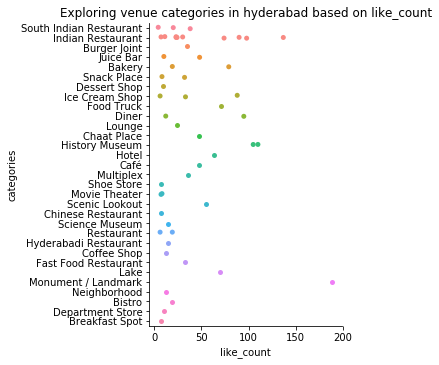

In [ ]:
#In Hyderabad
plt.figure(figsize=(12,18))
sns.catplot(x='like_count',y='categories',data=Hvenues_df)
plt.xlabel('like_count')
plt.title('Exploring venue categories in hyderabad based on like_count')
plt.show()

In Hyderabad, the most liked categories are Monument/Landmark & Indian restaurant and least liked category is Ice Cream Shop.

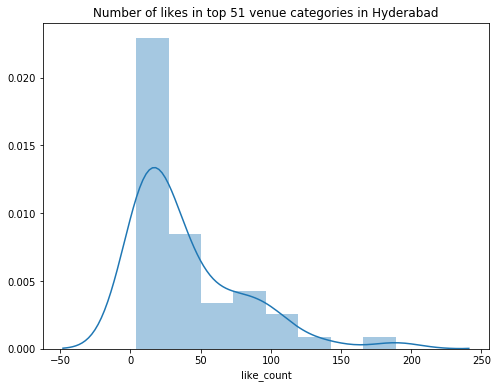

In [ ]:
# Average number of user likes that have been reported in venuue categories
plt.figure(figsize=(8,6))
sns.distplot(Hvenues_df['like_count'])
plt.title('Number of likes in top 51 venue categories in Hyderabad')
plt.show()

In [ ]:
print('Average number of user likes that have been reported in top 51 venuue categories in Hyderabad is {}'.format(int(Hvenues_df['like_count'].mean())))

Average number of user likes that have been reported in top 51 venuue categories in Hyderabad is 40


### Exploring venue categories based on tipCount

<Figure size 864x1296 with 0 Axes>

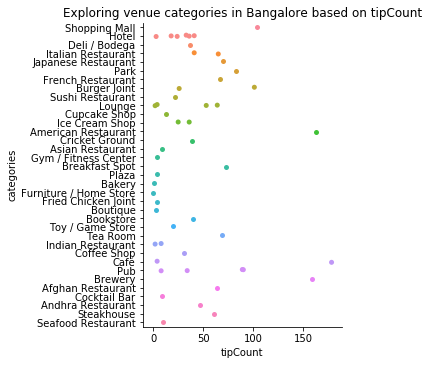

In [ ]:
#In Bangalore
plt.figure(figsize=(12,18))
sns.catplot(x='tipcount',y='categories',data=Bvenues_df)
plt.xlabel('tipCount')
plt.title('Exploring venue categories in Bangalore based on tipCount')
plt.show()

Categories Cafe, Brewery, & American restaurant have recieced highest tips & Lounge, Furniture/Home Store, & Hotel have recieved fewer tips.

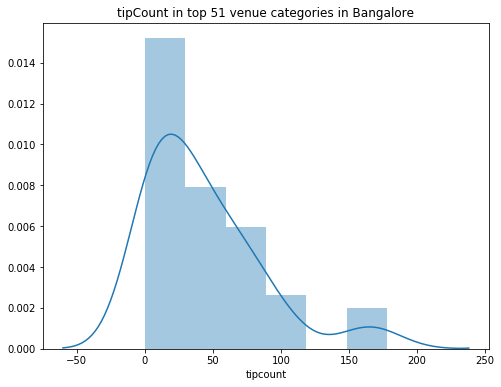

In [ ]:
# Average number of user tips that have been reported in venuue categories
plt.figure(figsize=(8,6))
sns.distplot(Bvenues_df['tipcount'])
plt.title('tipCount in top 51 venue categories in Bangalore')
plt.show()

In [ ]:
print('Average number of user tips that have been reported in top 51 venuue categories in Bangalore is {}'.format(int(Bvenues_df['tipcount'].mean())))

Average number of user tips that have been reported in top 51 venuue categories in Bangalore is 42


<Figure size 864x1296 with 0 Axes>

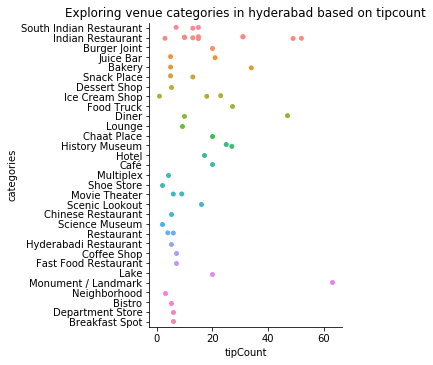

In [ ]:
#In Hyderabad
plt.figure(figsize=(12,18))
sns.catplot(x='tipcount',y='categories',data=Hvenues_df)
plt.xlabel('tipCount')
plt.title('Exploring venue categories in hyderabad based on tipcount')
plt.show()

Moument/Landmark category recieved highest tips & Ice Cream Shop category recieved lowest tips.

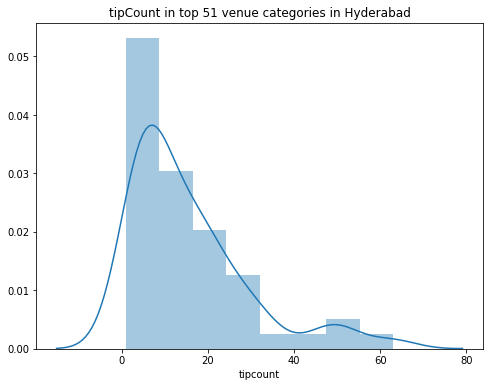

In [ ]:
# Average number of user tips that have been reported in venuue categories
plt.figure(figsize=(8,6))
sns.distplot(Hvenues_df['tipcount'])
plt.title('tipCount in top 51 venue categories in Hyderabad')
plt.show()

In [ ]:
print('Average number of user tips that have been reported in top 51 venuue categories in Hyderabad is {}'.format(int(Hvenues_df['tipcount'].mean())))

Average number of user tips that have been reported in top 51 venuue categories in Hyderabad is 15


### Exploring venue categories based on rating

<Figure size 864x1296 with 0 Axes>

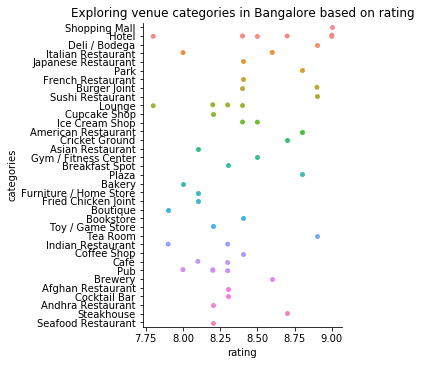

In [ ]:
#In Bangalore
plt.figure(figsize=(12,18))
sns.catplot(x='rating',y='categories',data=Bvenues_df)
plt.xlabel('rating')
plt.title('Exploring venue categories in Bangalore based on rating')
plt.show()

Users have given highest rating to Shopping Mall & a Hotel categories and given least rating to Lounge & a Hotel. ALL restaurants got above average ratings.

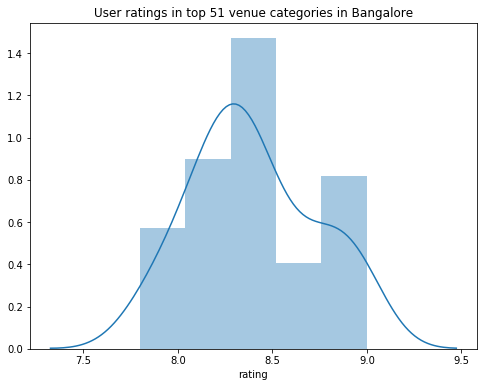

In [ ]:
# Average number of user ratings that have been reported in venuue categories
plt.figure(figsize=(8,6))
sns.distplot(Bvenues_df['rating'])
plt.title('User ratings in top 51 venue categories in Bangalore')
plt.show()

In [ ]:
print('Average number of user ratings that have been reported in top 51 venuue categories in Bangalore is {}'.format(int(Bvenues_df['rating'].mean())))

Average number of user ratings that have been reported in top 51 venuue categories in Bangalore is 8


Let's create bins for different ratings & plot them in different colors on map.Divide the rating into 3 bins.
* 6-7
* 7-8
* 8-9

In [ ]:
bins=[6.0,7.0,8.0,9.0]
labels=['Okay','Good','Very Good']
Bvenues_df['rating_bins']=pd.cut(Bvenues_df['rating'].astype('float'),bins=bins,labels=labels,include_lowest=True)
Bvenues_df.head()

,id,name,categories,lat,lng,address,tipcount,like_count,rating,ratingSignals,rating_bins
0,4bcd805cfb84c9b61512223e,UB City,Shopping Mall,12.971709,77.595905,at Vittal Mallya Rd,104,657,9.0,802,Very Good
1,51d1245e498ef93fd0e713bb,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051,24/1 Vittal Mallya Road,36,128,8.7,166,Very Good
2,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,"52,53",37,111,8.9,147,Very Good
3,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,UB City Level 2 Concorde Block,65,127,8.6,188,Very Good
4,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,"3rd Flr., UB City, Vittal Mallya Rd.",70,140,8.4,204,Very Good


Now will plot the venue categories on map

In [ ]:
colormap={'Okay':'darkblue','Good':'orange','Very Good':'green'}

for name,address,latitude,longitude,rating_bins in zip(Bvenues_df['name'],
                                                       Bvenues_df['address'],
                                                       Bvenues_df['lat'],
                                                       Bvenues_df['lng'],
                                                       Bvenues_df['rating_bins']):
    label="{},{}".format(name,address)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
    [latitude,longitude],
    icon=folium.Icon(color=colormap[rating_bins],icon='male',prefix='fa'),
    popup=label).add_to(Bangalore_map)
Bangalore_map

As you can see that, high rated venue categories (between 8 & 9) are clustered around Bangalore club, Vittal Malya road & Church street road.

<Figure size 864x1296 with 0 Axes>

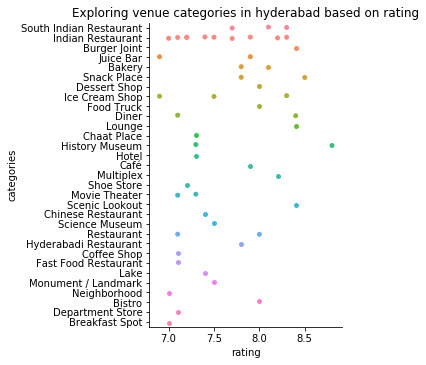

In [ ]:
#In Hyderabad
plt.figure(figsize=(12,18))
sns.catplot(x='rating',y='categories',data=Hvenues_df)
plt.xlabel('rating')
plt.title('Exploring venue categories in hyderabad based on rating')
plt.show()

History Museum got the highest rating & Ice Cream got the lowest rating. ALL restaurants got above average ratings.

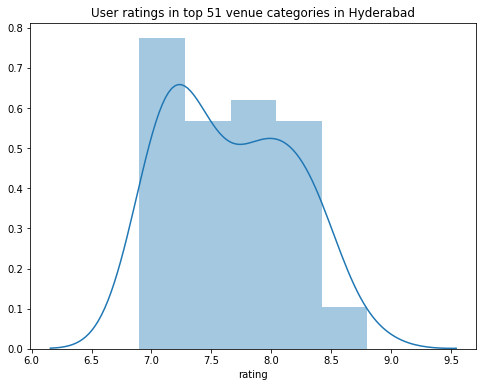

In [ ]:
# Average number of user ratings that have been reported in venuue categories
plt.figure(figsize=(8,6))
sns.distplot(Hvenues_df['rating'])
plt.title('User ratings in top 51 venue categories in Hyderabad')
plt.show()

In [ ]:
print('Average number of user ratings that have been reported in top 51 venuue categories in Hyderabad is {}'.format(int(Hvenues_df['rating'].mean())))

Average number of user ratings that have been reported in top 51 venuue categories in Hyderabad is 7


Let's create bins for different ratings & plot them in different colors on map.Divide the rating into 3 bins.
* 6-7
* 7-8
* 8-9

In [ ]:
bins=[6.0,7.0,8.0,9.0]
labels=['Okay','Good','Very Good']
Hvenues_df['rating_bins']=pd.cut(Hvenues_df['rating'].astype('float'),bins=bins,labels=labels,include_lowest=True)
Hvenues_df.head()

,id,name,categories,lat,lng,address,tipcount,like_count,rating,ratingSignals,rating_bins
0,4dc4a65e18506de4adc5d5e5,Pragati,South Indian Restaurant,17.388088,78.481134,"Kandaswamy Lane, Sultan Bazaar, Koti Andhra Pr...",15,38,8.3,55,Very Good
1,4d3d4eca14aa8cfaa6d6b15e,Santosh Dhaba,Indian Restaurant,17.388485,78.479509,NaN,15,23,8.2,40,Very Good
2,4df9c65c62e1e9a24367f9e5,King & Cardinal,Burger Joint,17.400678,78.488575,Himayatnagar,20,35,8.4,57,Very Good
3,4cdd08d4fc973704fe47d905,Mayur Pan Shop,Juice Bar,17.388894,78.480578,Hanuman Tekdi Rd.,21,48,7.9,71,Good
4,4e009da21838cb6a1acb225e,Minerva Coffee Shop,Indian Restaurant,17.401410,78.485672,Himyathnagar,31,74,8.3,108,Very Good


Now will plot the venue categories on map

In [ ]:
colormap={'Okay':'darkblue','Good':'orange','Very Good':'green'}

for name,address,latitude,longitude,rating_bins in zip(Hvenues_df['name'],
                                                       Hvenues_df['address'],
                                                       Hvenues_df['lat'],
                                                       Hvenues_df['lng'],
                                                       Hvenues_df['rating_bins']):
    label="{},{}".format(name,address)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
    [latitude,longitude],
    icon=folium.Icon(color=colormap[rating_bins],icon='male',prefix='fa'),
    popup=label).add_to(Hyderabad_map)
Hyderabad_map

As you can see that, high rated venue categories (between 7 & 8 and 8 & 9) are situated in Himayat Nagar, Abids, Basheer Bagh flyover road & Charminar road.

### Exploring venue categories based on ratingSignals (Number of ratings recieved)

<Figure size 864x1296 with 0 Axes>

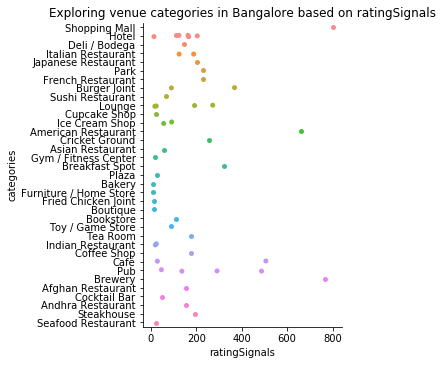

In [ ]:
#In Bangalore
plt.figure(figsize=(12,18))
sns.catplot(x='ratingSignals',y='categories',data=Bvenues_df)
plt.xlabel('ratingSignals')
plt.title('Exploring venue categories in Bangalore based on ratingSignals')
plt.show()

Brewery & Shoping mall category recieved highest number of ratings & least number of ratings recieved by a Hotel.

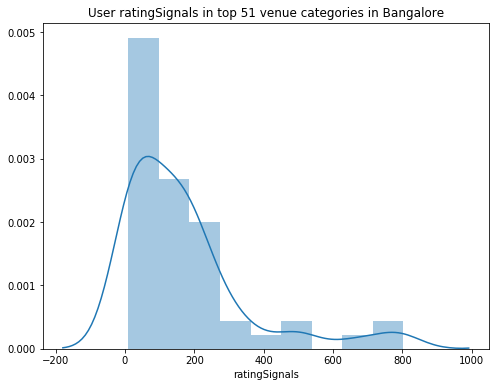

In [ ]:
# Average number of user ratingSignals that have been reported in venuue categories
plt.figure(figsize=(8,6))
sns.distplot(Bvenues_df['ratingSignals'])
plt.title('User ratingSignals in top 51 venue categories in Bangalore')
plt.show()

In [ ]:
print('Average number of user ratingSignals that have been reported in top 51 venuue categories in Bangalore is {}'.format(int(Bvenues_df['ratingSignals'].mean())))

Average number of user ratingSignals that have been reported in top 51 venuue categories in Bangalore is 170


<Figure size 864x1296 with 0 Axes>

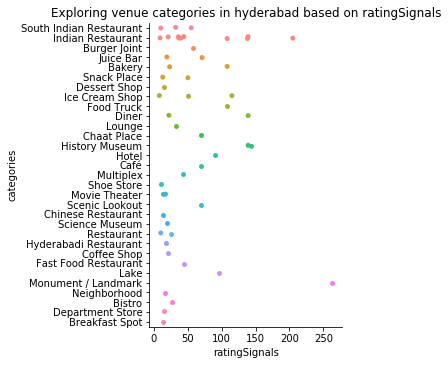

In [ ]:
#In Hyderabad
plt.figure(figsize=(12,18))
sns.catplot(x='ratingSignals',y='categories',data=Hvenues_df)
plt.xlabel('ratingSignals')
plt.title('Exploring venue categories in hyderabad based on ratingSignals')
plt.show()

Monument/Landmark & Ice cream shop categories have recieved highest & lowest number of ratings respectively.

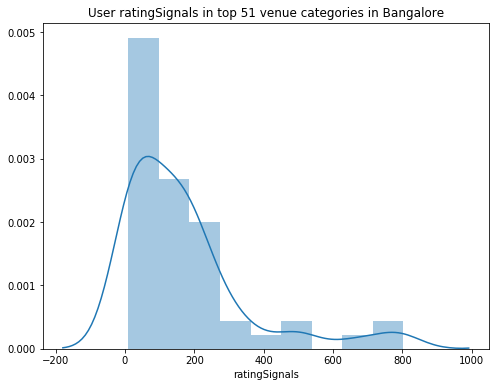

In [ ]:
# Average number of user ratingSignals that have been reported in venuue categories
plt.figure(figsize=(8,6))
sns.distplot(Bvenues_df['ratingSignals'])
plt.title('User ratingSignals in top 51 venue categories in Bangalore')
plt.show()

In [ ]:
print('Average number of user ratingSignals that have been reported in top 51 venuue categories in Hyderabad is {}'.format(int(Hvenues_df['ratingSignals'].mean())))

Average number of user ratingSignals that have been reported in top 51 venuue categories in Hyderabad is 57


# Clustering of Venue Categories & Key take aways

Now we will cluster venue categories based on geo coordinates, like count, tipcount, rating & ratingSignals using K-means clustering.

In [ ]:
#Select the required columns for clustering
cols=['lat','lng','like_count','tipcount','rating','ratingSignals']
Bselected_clusters=Bvenues_df[cols]
Hselected_clusters=Hvenues_df[cols]

### For Bangalore

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
n_clusters=3  # Considering based on bins
Bkmeans=KMeans(n_clusters=n_clusters,random_state=20).fit(Bselected_clusters)
Bkmeans.labels_

array([0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 2, 2, 1, 2, 1,
       1, 2, 1, 1, 2, 1, 1], dtype=int32)

In [ ]:
#Insert cluster labels to the original dataframe
Bvenues_df.insert(0,'Cluster_labels',Bkmeans.labels_)
Bvenues_df=Bvenues_df.drop('Cluster labels',axis=1)
Bvenues_df.head()

,Cluster_labels,id,name,categories,lat,lng,address,tipcount,like_count,rating,ratingSignals,rating_bins
0,0,4bcd805cfb84c9b61512223e,UB City,Shopping Mall,12.971709,77.595905,at Vittal Mallya Rd,104,657,9.0,802,Very Good
1,2,51d1245e498ef93fd0e713bb,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051,24/1 Vittal Mallya Road,36,128,8.7,166,Very Good
2,2,520390f3498ebe0f1dd63e9e,Smoke House Deli,Deli / Bodega,12.971656,77.598254,"52,53",37,111,8.9,147,Very Good
3,2,4bc1cd90b492d13a4e74a660,Toscano,Italian Restaurant,12.971980,77.596066,UB City Level 2 Concorde Block,65,127,8.6,188,Very Good
4,2,4b895510f964a520442c32e3,Shiro,Japanese Restaurant,12.971900,77.596236,"3rd Flr., UB City, Vittal Mallya Rd.",70,140,8.4,204,Very Good


Now plot cluster labels on map

In [ ]:
 colormap={0:'darkblue',1:'orange',2:'green'}

for name,address,latitude,longitude,cluster in zip(Bvenues_df['name'],
                                                       Bvenues_df['address'],
                                                       Bvenues_df['lat'],
                                                       Bvenues_df['lng'],
                                                       Bvenues_df['Cluster_labels']):
    label="{},{}".format(name,address)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
    [latitude,longitude],
    icon=folium.Icon(color=colormap[cluster],icon='male',prefix='fa'),
    popup=label).add_to(Bangalore_map)
    
#add cluster centers to the map
for index,cluster in enumerate(Bkmeans.cluster_centers_):
    latitude=cluster[0]
    longitude=cluster[1]
    label=folium.Popup('Cluster'+','+str(index),parse_html=True)
    folium.Marker(
    [latitude,longitude],
    icon=folium.Icon(color=colormap[index]),
    popup=label).add_to(Bangalore_map)
    
Bangalore_map

#### Key take aways
From the map, we could say that,

1. Cluster first is spreaded across the whole city & has majority venues.
2. Cluster second & three are spreaded at the city center & have limited venues.


### For Hyderabad

In [ ]:
n_clusters=3  # Considering based on bins
Hkmeans=KMeans(n_clusters=n_clusters,random_state=20).fit(Hselected_clusters)
Hkmeans.labels_

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
#Insert cluster labels to the original dataframe
Hvenues_df.insert(0,'Cluster_labels',Hkmeans.labels_)
Hvenues_df.head()

,Cluster_labels,id,name,categories,lat,lng,address,tipcount,like_count,rating,ratingSignals,rating_bins
0,0,4dc4a65e18506de4adc5d5e5,Pragati,South Indian Restaurant,17.388088,78.481134,"Kandaswamy Lane, Sultan Bazaar, Koti Andhra Pr...",15,38,8.3,55,Very Good
1,0,4d3d4eca14aa8cfaa6d6b15e,Santosh Dhaba,Indian Restaurant,17.388485,78.479509,NaN,15,23,8.2,40,Very Good
2,0,4df9c65c62e1e9a24367f9e5,King & Cardinal,Burger Joint,17.400678,78.488575,Himayatnagar,20,35,8.4,57,Very Good
3,0,4cdd08d4fc973704fe47d905,Mayur Pan Shop,Juice Bar,17.388894,78.480578,Hanuman Tekdi Rd.,21,48,7.9,71,Good
4,1,4e009da21838cb6a1acb225e,Minerva Coffee Shop,Indian Restaurant,17.401410,78.485672,Himyathnagar,31,74,8.3,108,Very Good


Now plot cluster labels on map

In [ ]:
 colormap={0:'darkblue',1:'orange',2:'green'}

for name,address,latitude,longitude,cluster in zip(Hvenues_df['name'],
                                                       Hvenues_df['address'],
                                                       Hvenues_df['lat'],
                                                       Hvenues_df['lng'],
                                                       Hvenues_df['Cluster_labels']):
    label="{},{}".format(name,address)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
    [latitude,longitude],
    icon=folium.Icon(color=colormap[cluster],icon='male',prefix='fa'),
    popup=label).add_to(Hyderabad_map)
    
#add cluster centers to the map
for index,cluster in enumerate(Hkmeans.cluster_centers_):
    latitude=cluster[0]
    longitude=cluster[1]
    label=folium.Popup('Cluster'+','+str(index),parse_html=True)
    folium.Marker(
    [latitude,longitude],
    icon=folium.Icon(color=colormap[index]),
    popup=label).add_to(Hyderabad_map)
    
Hyderabad_map

#### Key take aways
From above plot, we could say that,
1. Cluster first is spread across the whole city & has majority venues.
2. Cluster second & third are less sparsely spread & have limited venues.

## Conclusions:

#### From above insights, I would recommend to explore,
#### 1. Bangalore, if you are a foodie, want to try & explore a wide variety of cuisines such as Japanese, French, American, Indain & a lot more. Also love to do shoping, Bangalore has higjhest rated shopping malls.
#### 2. Hyderbad, if you want to try Indian cuisines, specially Hyderabadi Biryani & would love to visit historical places such as Museums, Monument (Charminar), river (Hussain sagar), which have rated highest & got maximum likes & tips.
#### 3. Bangalore, if you want high rated & most liked venue categories spread across the city.